Напишите простую сверточную нейронную сеть для задачи классификации картинок из базы cifar10. Используя библиотеку gTTS, напишите колбэк, при помощи которого (после обучения сети), автоматически будет воспроизводиться фраза "Обучение закончено. Точность сети на проверочной выборке {здесь озвучивается точность в процентах}".

In [ ]:
%%capture

# Бесплатная библиотека Google для задачи TTS
!pip install gTTS

In [ ]:
# Импорт библиотеки google-cloud-texttospeech
import gtts 

# Основной интерфейс для перевода текста в аудио
from gtts import gTTS 

# Интерактивная оболочка языка python
import IPython

# Используем для проигрывания аудио
from IPython.display import Audio 

# Загружаем базу cifar10
from tensorflow.keras.datasets import cifar10 

# Сеть прямого распространения
from tensorflow.keras.models import Sequential 

# Базовые слои для счёрточных сетей
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization

# Для создания самописного колбэка
from tensorflow.keras.callbacks import LambdaCallback

# Используем для to_categorical
from tensorflow.keras import utils 

# Для отрисовки изображений
from tensorflow.keras.preprocessing import image 

# Библиотека работы с массивами
import numpy as np 

# Для отрисовки графиков
import matplotlib.pyplot as plt 

# Для отрисовки изображений
from PIL import Image 

Загружаем базу cifar10, она в свободном доступе.

In [ ]:
# Загружаем датасет cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


Выводим для примера картинки по каждому классу.

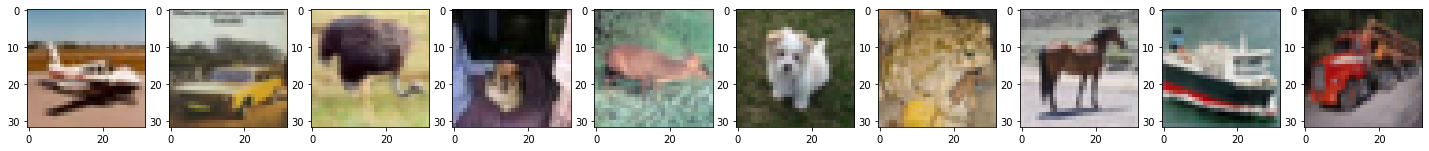

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=(25, 3)) # Создаем полотно из 10 графиков

# Проходим по классам от 0 до 9
for i in range(10):                             
  
  # Получаем список из индексов положений класса i в y_train
  label_indexes = np.where(y_train==i)[0]       
  
  # Случайным образом выбираем из списка индекс
  index = np.random.choice(label_indexes)       
  
  # Выбираем из x_train нужное изображение
  img = x_train[index]                          
  
  # Отображаем изображение i-ым графиков
  axs[i].imshow(Image.fromarray(img))           

In [ ]:
# Превращаем y_train и y_test сетей в формат one hot encoding

y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

In [ ]:
# Посмотрим форматы выборок перед обучением

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)


In [ ]:
# Функция, которую будем запускать после каждой эпохи
def on_train_end(logs):

    # В тексте добавим значение val_accuracy на последней эпохе
    text = 'Обучение закончено. Точность сети на проверочной выборке составляет '+str(int(round(logs['val_accuracy']*100, 0)))+' Процентов'

    tts = gTTS(text, lang='ru') # Преобразуем текст в аудио
    tts.save('signal.mp3')      # Сохраняем в формате мр3

    # Без функции IPython.display.display() воспроизведение не получится
    IPython.display.display(Audio('signal.mp3', autoplay=True))

Добавляем самописный колбэк в переменную.

In [ ]:
# Коллбэк
train_end = LambdaCallback(on_train_end=on_train_end)

Теперь создадим нейронную сеть и обучим её.

In [ ]:
model = Sequential()                                             # Создаем последовательную модель
model.add(BatchNormalization(input_shape=(32, 32, 3)))           # Слой пакетной нормализации
model.add(Conv2D(32, (3, 3), padding='same', activation='relu')) # Первый сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu')) # Второй сверточный слой
model.add(MaxPooling2D(pool_size=(2, 2)))                        # Первый слой подвыборки
model.add(Flatten())                                             # Выравнивающий слой
model.add(Dense(256, activation='relu'))                         # Полносвязный слой для классификации
model.add(Dense(10, activation='softmax'))                       # Выходной полносвязный слой

# Компилируем сеть
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Обучаем сеть

history = model.fit(x_train,                  # Обучающие данные
                    y_train, 
                    batch_size=32,            # Размер пакета
                    epochs=3,                 # Количество эпох
                    validation_data=(x_test,  # Проверочные данные
                                     y_test),
                    callbacks=train_end,      # Колбэк
                    verbose=1)                # Вывести на экран прогрессбар

Epoch 1/3
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2186 - accuracy: 0.5724 - val_loss: 0.9573 - val_accuracy: 0.6613
Epoch 2/3
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8317 - accuracy: 0.7108 - val_loss: 0.9109 - val_accuracy: 0.6841
Epoch 3/3
1563/1563 [==============================] - 7s 4ms/step - loss: 0.6018 - accuracy: 0.7903 - val_loss: 0.9316 - val_accuracy: 0.6947


По завершении обучения, автоматически воспроизводится аудиозапись, что обучение окончено с определенным значением точности.